# Basic investigation of an LAS file
This notebook provides an example of examining an LAS file using Python's
basic data science tools. The basic process is as follows:
* read an LAS file into a dataframe (as tabular data)
* plot some histograms based on the point data
* map each point to a raster cell
* convert the raster to an image and display

### Start by importing some basic tools
_laspy_ -- a python package used to read LAS files<br>
_pandas_ -- Python's excellent Data Analysis Library<br>
_datashader_ -- high-level visualization tool for large data<br>
_matplotlib_ -- low-level plotting library (used for colormaps)

In [1]:
import os
import pandas as pd
from laspy.file import File
import xarray as xa
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib import cm

### Open the LAS file and create a dataframe
We only imported the File object from the laspy. We'll use that to read the LAS file and import the X,Y,Z coordinates and point classification into a panda's dataframe. The next couple of cells show different ways of looking at the dataframe.

_Yes, there really is a space before the filename. Yes, it drives me nuts too. Some of this will be cleaned up in the future._

In [2]:
fname = '/home/jovyan/lidar/piatt/LAS/ 934_1294.las'
inFile = File(fname, mode='r')
df = pd.DataFrame() 
df['X'] = inFile.x 
df['Y'] = inFile.y 
df['Z'] = inFile.z
df['class'] = inFile.classification

##### Print the minimum and maximum Z values and the first 5 points in the LAS file

In [3]:
print ("min Z = {}, max Z = {}".format(df['Z'].min(), df['Z'].max()))
df.head(6)

min Z = 713.98, max Z = 814.16


,X,Y,Z,class
0,934001.30,1295997.14,730.28,1
1,934001.11,1295996.18,730.34,1
2,934002.07,1295989.40,730.19,1
3,934002.20,1295981.86,730.33,1
4,934000.97,1295980.93,730.23,1
5,934001.31,1295974.21,730.16,1


##### Create a histogram on the X,Y, and Z values

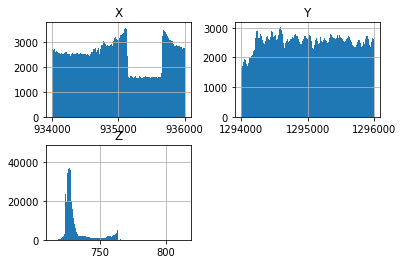

In [11]:
bins = df.hist(column=['X','Y','Z'],bins=400)

_Notice the notch in the X-axis. I'm not sure why this exists in the LAS file and I'm not sure if the difference in point density would have other implications when creating elevation maps. This band is also visible in the raster data shown below._

### Basic rasterization using datashader
Datashader allows LiDAR points from the dataframe to be easily aggregated into a raster. This is a simple rasterization where only LAS points within a cell's boundary and can impact the raster cell's final value. This limiation prevents some types of smoothing but this is ideal for quick inspection.

The code below shows how to aggregate the LAS points into raster with 5 foot resolution. The raster cell's value is based on the count of LAS points contained within the cell (using agg=ds.count() parameter). In this case, vegitation is clearly visible because of the multiple returns. Other notable features are the lack of returns in the lower left corner because of water and the clearly visible band with low return count.

Other visualization options include the use of ds.any() that would provide a mask about which cells contain LAS points and ds.min('Z') which would choose the lowest elevation of all the points in the cell.

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


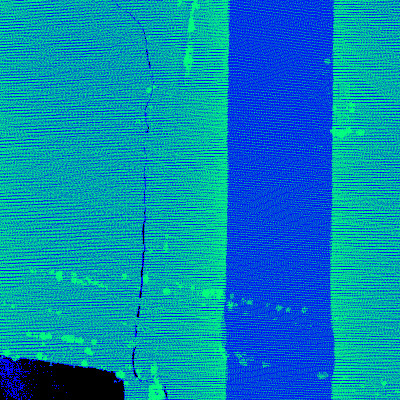

In [13]:
resolution = 5
width = int(round(df['X'].max() - df['X'].min())/resolution)
height = int(round(df['Y'].max() - df['Y'].min())/resolution)
cvs = ds.Canvas(plot_width=width, plot_height=height)
raster = cvs.points(df, 'X', 'Y', agg=ds.count())
tf.set_background(tf.shade(raster, cmap=cm.winter), "black")

##  
In the following visualization, the minimum Z value (lowest elevation) is used along with the terrain colormap. 
Notable is the visibility of buildings but lack of visible vegitation.

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


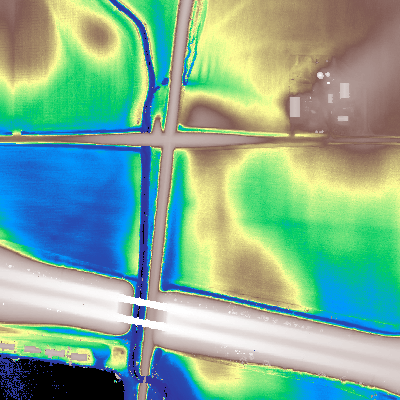

In [35]:
resolution = 5
width = int(round(df['X'].max() - df['X'].min())/resolution)
height = int(round(df['Y'].max() - df['Y'].min())/resolution)
cvs = ds.Canvas(plot_width=width, plot_height=height)
raster = cvs.points(df, 'X', 'Y', agg=ds.min('Z'))
tf.set_background(tf.shade(raster, cmap=cm.terrain), "black")

##  
The following code produces a raster based only on points classified as "ground" points. Notable are the large number of cells (including buildings, bridges and waterways) which are excluded.

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


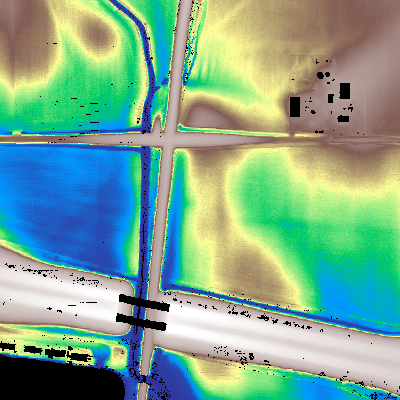

In [31]:
gnd = df[df['class']==2]
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(gnd, 'X', 'Y', agg=ds.min('Z'))
tf.set_background(tf.shade(agg, cmap=cm.terrain),"black", name='Ground')

##  
The final visualization is looks only at the points classified as water.

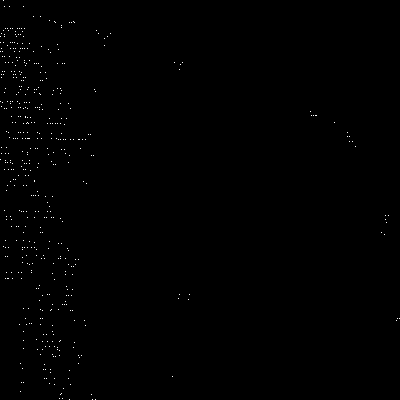

In [29]:
water = df[df['class']==9]
cvs = ds.Canvas(plot_width=400, plot_height=400)
raster = cvs.points(water, 'X', 'Y', agg=ds.any())
tf.set_background(tf.shade(raster, cmap='white'),"black")